## Set up

In [17]:
import pickle
from pathlib import Path

import keras as tfk
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.data import Dataset as tfds

sns.set_theme()

In [18]:
EXPERIMENT = "14-l2_higher"
EXPERIMENT_DIR = Path().absolute().parent / "results" / EXPERIMENT

MODEL_PATH = EXPERIMENT_DIR / "model.keras"
HISTORY_PATH = EXPERIMENT_DIR / "history.pkl"
TRAIN_PREDICTIONS_PATH = EXPERIMENT_DIR / "train_predictions.npy"
VAL_PREDICTIONS_PATH = EXPERIMENT_DIR / "val_predictions.npy"

### Load model

In [19]:
model: tfk.Model = tfk.saving.load_model(MODEL_PATH)
model

<Functional name=functional_3, built=True>

In [20]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,785,306 (14.44 MB)

 Trainable params: 262,984 (1.00 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 525,970 (2.01 MB)

In [21]:
layer_weights: list[np.ndarray] = [
    model.layers[i].weights[0].numpy().flatten()
    for i in (-3, -2, -1)
]

<Axes: >

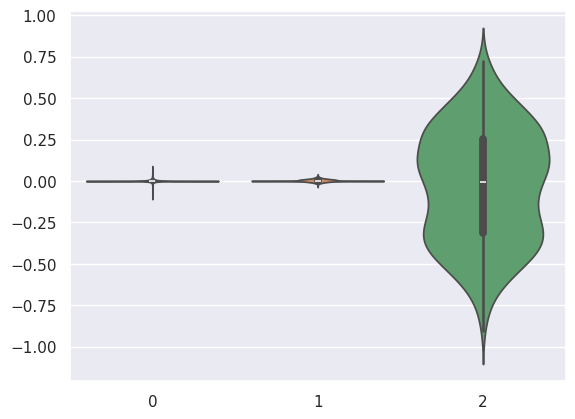

In [22]:
sns.violinplot(layer_weights)

### Load data

In [23]:
BATCH_SIZE = 128
AUGMENTED_DIR = Path().absolute().parent / "data" / "augmented"
TRAIN_TFDS_DIR = AUGMENTED_DIR / "train"
VAL_TFDS_DIR = AUGMENTED_DIR / "val"

train_dataset: tfds = tfds.load(str(TRAIN_TFDS_DIR)).batch(BATCH_SIZE)
val_dataset: tfds = tfds.load(str(VAL_TFDS_DIR)).batch(BATCH_SIZE)

train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None))>

### Load predictions

In [24]:
y_train_pred = np.load(TRAIN_PREDICTIONS_PATH)
y_val_pred = np.load(VAL_PREDICTIONS_PATH)

In [25]:
y_train = np.concatenate(
    list(train_dataset.map(lambda _, y: y).as_numpy_iterator())
)
y_val = np.concatenate(
    list(val_dataset.map(lambda _, y: y).as_numpy_iterator())
)

print(y_train.shape)
print(y_val.shape)

(31688, 8)
(5592, 8)


2024-11-15 12:54:30.308465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-15 12:54:30.426909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
def decode(one_hot: np.ndarray) -> np.ndarray:
    return np.argmax(one_hot, axis=1)

In [27]:
label_train = decode(y_train)
label_val = decode(y_val)

label_train_pred = decode(y_train_pred)
label_val_pred = decode(y_val_pred)

In [28]:
outputs = {
    "train": (label_train, label_train_pred),
    "val": (label_val, label_val_pred),
}
outputs

{'train': (array([1, 0, 7, ..., 1, 0, 0]), array([2, 2, 5, ..., 6, 7, 5])),
 'val': (array([1, 4, 4, ..., 2, 6, 1]), array([5, 7, 4, ..., 0, 1, 0]))}

### Load history

In [29]:
with HISTORY_PATH.open("rb") as f:
    history: tfk.callbacks.History = pickle.load(f)
history_df = pd.DataFrame(history.history)
f1_df = history_df.filter(like="f1_score")
history_df = history_df[history_df.columns.difference(f1_df.columns)]
history_df

,accuracy,learning_rate,loss,recall,val_accuracy,val_loss,val_recall
0,0.719366,0.0001,12.187338,0.461004,0.868432,8.987247,0.763563
1,0.886442,0.0001,7.069105,0.804160,0.901965,5.462079,0.828492
2,0.904852,0.0001,4.390739,0.839634,0.909440,3.486712,0.843657
3,0.911806,0.0001,2.874948,0.851519,0.914353,2.357429,0.848996
4,0.914104,0.0001,2.002165,0.856942,0.917343,1.700939,0.853054
...,...,...,...,...,...,...,...
83,0.935670,0.0001,0.443322,0.907150,0.934857,0.445250,0.908800
84,0.935792,0.0001,0.442435,0.907334,0.935498,0.444045,0.909440
85,0.935884,0.0001,0.441582,0.907456,0.935711,0.443265,0.909654
86,0.935945,0.0001,0.440709,0.907609,0.935711,0.442498,0.909868


## Analyse

### History

In [30]:
molten_history = history_df.reset_index().melt(id_vars="index")
molten_history["val"] = molten_history["variable"].str.contains("val_")
molten_history["variable"] = molten_history["variable"].str.replace("val_", "")
molten_history

,index,variable,value,val
0,0,accuracy,0.719366,False
1,1,accuracy,0.886442,False
2,2,accuracy,0.904852,False
3,3,accuracy,0.911806,False
4,4,accuracy,0.914104,False
...,...,...,...,...
611,83,recall,0.908800,True
612,84,recall,0.909440,True
613,85,recall,0.909654,True
614,86,recall,0.909868,True


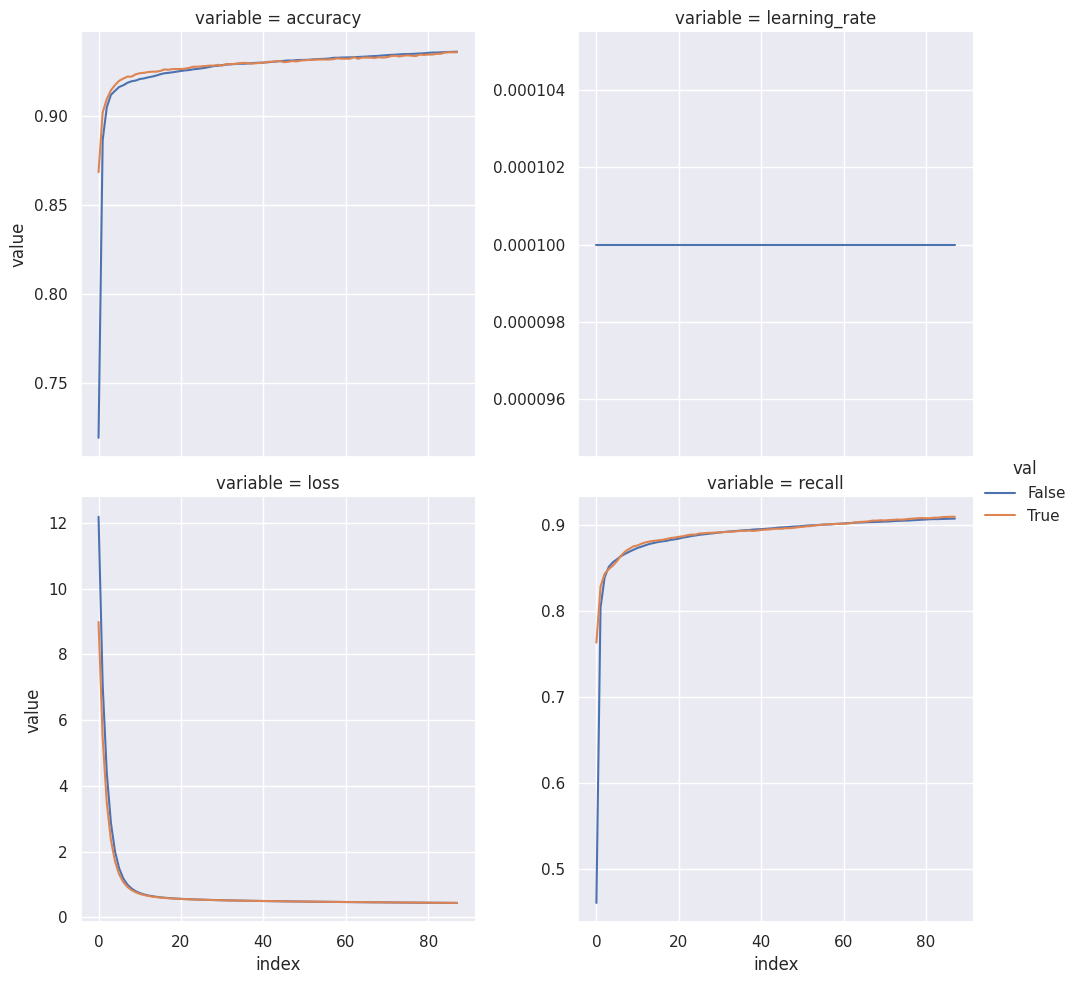

In [31]:
sns.relplot(
    molten_history,
    x="index",
    y="value",
    col="variable",
    col_wrap=2,
    hue="val",
    facet_kws={"sharey": False},
    kind="line",
)

### Classification metrics

In [32]:
for set_, (y_true, y_pred) in outputs.items():
    print(set_)
    print(classification_report(y_true, y_pred))
    print()

train


ValueError: Found input variables with inconsistent numbers of samples: [31688, 32644]

### Confusion matrices

In [ ]:
def confusion_diag_zero(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    matrix[np.diag_indices_from(matrix)] = 0
    ax = sns.heatmap(matrix, annot=True, fmt="d")
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    return ax

Text(0.5, 1.0, 'train')

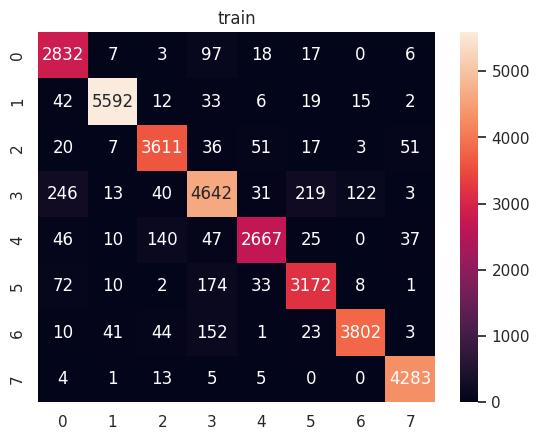

In [ ]:
ax = sns.heatmap(confusion_matrix(*outputs["train"]), annot=True, fmt="d")
ax.set_title("train")

<Axes: xlabel='Predicted', ylabel='True'>

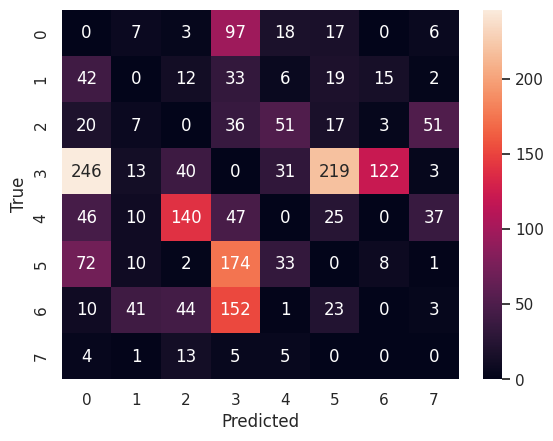

In [ ]:
confusion_diag_zero(*outputs["train"])

Text(0.5, 1.0, 'val')

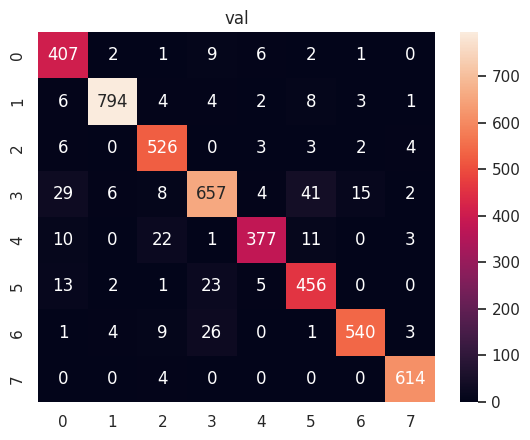

In [ ]:
ax = sns.heatmap(confusion_matrix(*outputs["val"]), annot=True, fmt="d")
ax.set_title("val")

<Axes: xlabel='Predicted', ylabel='True'>

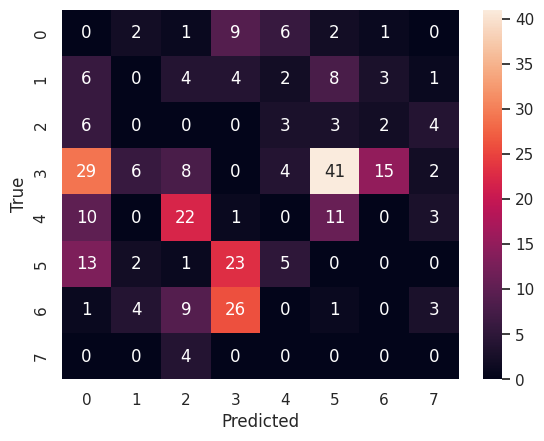

In [ ]:
confusion_diag_zero(*outputs["val"])